# 目的
株価が過去1年の平均から、変化している場合に
その後の値段が戻ろうとするか調査する

# 方法
2019/6/15の終値が、過去1年の終値の平均から標準偏差いくつ分下げているかで銘柄をカテゴライズ

カテゴリー毎にその後半年での値動きを確認
  
※ 値動きは、30日間の移動平均を日ごとにプロットし、  
その近似直線の傾きにて、値上がり・値下がりを判断する

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
import sys
sys.path.append('../src')

### データの読込

In [3]:
from data_control import data as dt
from analyze import graph as gh
from database.models import DailyChart

In [4]:
bgn_datetime = datetime(2018, 6, 16)
base_datetime = datetime(2019, 6, 15)
end_datetime = datetime(2019, 12, 15)

In [5]:
all_data = DailyChart.date_between(bgn_datetime, end_datetime)

2021-10-15 13:58:51,072 INFO sqlalchemy.engine.Engine SHOW VARIABLES LIKE 'sql_mode'
2021-10-15 13:58:51,073 INFO sqlalchemy.engine.Engine [raw sql] {}
2021-10-15 13:58:51,091 INFO sqlalchemy.engine.Engine SHOW VARIABLES LIKE 'lower_case_table_names'
2021-10-15 13:58:51,092 INFO sqlalchemy.engine.Engine [generated in 0.00089s] {}
2021-10-15 13:58:51,095 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2021-10-15 13:58:51,097 INFO sqlalchemy.engine.Engine [raw sql] {}
2021-10-15 13:58:51,118 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-10-15 13:58:51,123 INFO sqlalchemy.engine.Engine SELECT daily_chart.chart_date AS daily_chart_chart_date, daily_chart.description_code AS daily_chart_description_code, daily_chart.open AS daily_chart_open, daily_chart.high AS daily_chart_high, daily_chart.low AS daily_chart_low, daily_chart.close AS daily_chart_close, daily_chart.turnover AS daily_chart_turnover, daily_chart.vwap AS daily_chart_vwap, daily_chart.execution_count AS daily_chart_execut

In [6]:
data = dt.separate_by_code(all_data)
data = dt.filter_missing_stocks(data, bgn_datetime, end_datetime)

In [7]:
# 銘柄数
len(data.keys())

2984

### 平均から現在値がどれくらい乖離しているかでカテゴライズ

In [8]:
df = pd.DataFrame()
for code, d in data.items():
    d[(d['chart_date'] >= datetime(2018, 6, 16)) & (d['chart_date'] <= datetime(2019, 6, 15))]
    describe = pd.DataFrame([d['close'].describe()[['mean', 'std']]])
    describe['code'] = code
    describe['now'] = float(d.sort_values('chart_date').tail(1)['close'])
    df = pd.concat([df, describe])
df = df.reset_index().drop('index', axis=1)

In [9]:
df.head()

,mean,std,code,now
0,3014.326923,236.717160,1301,2852.0
1,1702.041209,84.510165,1305,1825.0
2,1679.994505,83.166334,1306,1802.0
3,1662.250000,82.102473,1308,1782.0
4,30454.120879,2080.388432,1309,34900.0


In [10]:
df['gap'] = df['now'] - df['mean']
df['gap_rate'] = df['gap'] / df['std']

In [11]:
down_over_2std_codes = df[df['gap_rate'] <= -2.0].code
down_between_1_5_and_2_0std_codes = df[(-2.0 < df['gap_rate']) & (df['gap_rate'] <= -1.5)].code
down_between_1_0_and_1_5std_codes = df[(-1.5 < df['gap_rate']) & (df['gap_rate'] <= -1.0)].code
down_between_0_5_and_1_0std_codes = df[(-1.0 < df['gap_rate']) & (df['gap_rate'] <= -0.5)].code
down_between_0_0_and_0_5std_codes = df[(-0.5 < df['gap_rate']) & (df['gap_rate'] <= -0)].code
up_between_0_0_and_0_5std_codes = df[(0.0 < df['gap_rate']) & (df['gap_rate'] <= 0.5)].code
up_between_0_5_and_1_0std_codes = df[(0.5 < df['gap_rate']) & (df['gap_rate'] <= 1.0)].code
up_between_1_0_and_1_5std_codes = df[(1.0 < df['gap_rate']) & (df['gap_rate'] <= 1.5)].code
up_between_1_5_and_2_0std_codes = df[(1.5 < df['gap_rate']) & (df['gap_rate'] <= 2.0)].code
up_over_2std_codes = df[(2.0 < df['gap_rate'])].code

In [12]:
print('2σ以上下がっている銘柄数: {}'.format(len(down_over_2std_codes)))
print('1.5σ ~ 2.0σ下がっている銘柄数: {}'.format(len(down_between_1_5_and_2_0std_codes)))
print('1.0σ ~ 1.5σ下がっている銘柄数: {}'.format(len(down_between_1_0_and_1_5std_codes)))
print('0.5σ ~ 1.0σ下がっている銘柄数: {}'.format(len(down_between_0_5_and_1_0std_codes)))
print('0.0σ ~ 0.5σ下がっている銘柄数: {}'.format(len(down_between_0_0_and_0_5std_codes)))
print('0.0σ ~ 0.5σ上がって柄数数: {}'.format(len(up_between_0_0_and_0_5std_codes)))
print('0.5σ ~ 1.0σ上がって柄数数: {}'.format(len(up_between_0_5_and_1_0std_codes)))
print('1.0σ ~ 1.5σ上がって柄数数: {}'.format(len(up_between_1_0_and_1_5std_codes)))
print('1.5σ ~ 2.0σ上がって柄数数: {}'.format(len(up_between_1_5_and_2_0std_codes)))
print('2σ以上上がっている銘柄数: {}'.format(len(up_over_2std_codes)))

2σ以上下がっている銘柄数: 16
1.5σ ~ 2.0σ下がっている銘柄数: 41
1.0σ ~ 1.5σ下がっている銘柄数: 212
0.5σ ~ 1.0σ下がっている銘柄数: 507
0.0σ ~ 0.5σ下がっている銘柄数: 515
0.0σ ~ 0.5σ上がって柄数数: 398
0.5σ ~ 1.0σ上がって柄数数: 354
1.0σ ~ 1.5σ上がって柄数数: 332
1.5σ ~ 2.0σ上がって柄数数: 257
2σ以上上がっている銘柄数: 352


In [13]:
# 割合
print(len(down_over_2std_codes) / len(data.keys()))
print(len(down_between_1_5_and_2_0std_codes) / len(data.keys()))
print(len(down_between_1_0_and_1_5std_codes) / len(data.keys()))
print(len(down_between_0_5_and_1_0std_codes) / len(data.keys()))
print(len(down_between_0_0_and_0_5std_codes) / len(data.keys()))
print(len(up_between_0_0_and_0_5std_codes) / len(data.keys()))
print(len(up_between_0_5_and_1_0std_codes) / len(data.keys()))
print(len(up_between_1_0_and_1_5std_codes) / len(data.keys()))
print(len(up_between_1_5_and_2_0std_codes) / len(data.keys()))
print(len(up_over_2std_codes) / len(data.keys()))

0.005361930294906166
0.013739946380697051
0.07104557640750671
0.16990616621983914
0.17258713136729223
0.1333780160857909
0.11863270777479892
0.11126005361930295
0.0861260053619303
0.11796246648793565


### 値動きを調べる

In [14]:
# 30日移動平均を取得
data = dt.calc_moving_average(data, days=30, column='close')

In [15]:
# MEMO: +/-の数 最高いくら利益が、どのくらいの期間で取れるか、　損に関しても同様

In [16]:
def check(code_list: list, show_graph=False):
    grad_list = list()
    max_list = list()
    max_days_list = list()
    min_list = list()
    min_days_list = list()

    for code in code_list:
        # データの絞り込み
        d = data[code]
        d = d[d['chart_date'] >= datetime(2019, 6, 15)]
        d = d.reset_index()
        # 回帰直線の追加
        x = np.linspace(1, len(d), len(d))
        a, b = np.polyfit(x, d['m_avg_30_close'], 1)
        regression_line = a * x + b
        d = d.assign(regression=regression_line)
        # 損益の取得
        buy = float(d.head(1)['close'])
        std = float(d.head(1)['m_std_30_close'])
        d['profit_or_loss'] = d['m_avg_30_close'] - buy
        max_idx = d['profit_or_loss'].idxmax()
        min_idx = d['profit_or_loss'].idxmin()
        max_by_std = float(d[d.index==max_idx]['profit_or_loss']) / std
        min_by_std = float(d[d.index==min_idx]['profit_or_loss']) / std
        # 集計
        grad_list.append(a)
        max_list.append(max_by_std)
        max_days_list.append(max_idx)
        min_list.append(min_by_std)
        min_days_list.append(min_idx)
        # グラフの描画
        if show_graph:
            print(code)
            gh.show_graph_together(d, ['m_avg_30_close', 'regression'], ['b', 'r'])
    
    check_df = pd.DataFrame()
    check_df = check_df.assign(grad=grad_list)
    check_df = check_df.assign(max_profit=max_list)
    check_df = check_df.assign(max_days=max_days_list)
    check_df = check_df.assign(min_profit=min_list)
    check_df = check_df.assign(min_days=min_days_list)
    return check_df

### 全銘柄

In [17]:
check_df = check(data.keys())

In [18]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0])

In [19]:
check_df.describe()

,grad,max_profit,max_days,min_profit,min_days
count,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000
mean,7.331298,4.687612,83.983244,-1.962989,47.860925
std,56.265449,6.904889,47.434904,2.205276,35.641176
min,-35.249139,-2.682414,0.000000,-19.543498,0.000000
25%,-0.246545,1.067466,33.000000,-2.820242,8.000000
50%,0.483714,2.926267,115.000000,-1.443152,59.000000
75%,2.010867,6.389981,122.000000,-0.479429,65.000000
max,1038.568551,206.042407,122.000000,1.871544,122.000000


In [20]:
print('plus: {}'.format(plus / len(data)))
print('minus: {}'.format(minus / len(data)))

plus: 0.6715817694369973
minus: 0.3284182305630027


### 2.0σ 以上下がった銘柄

1356


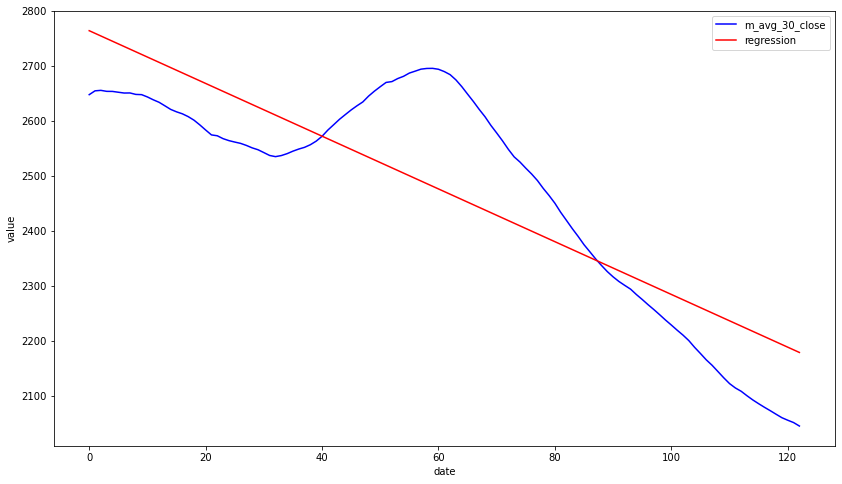

1357


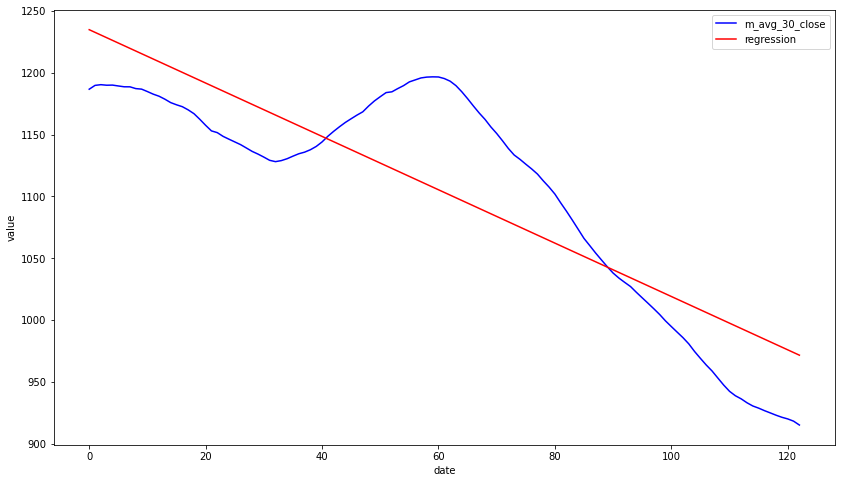

1360


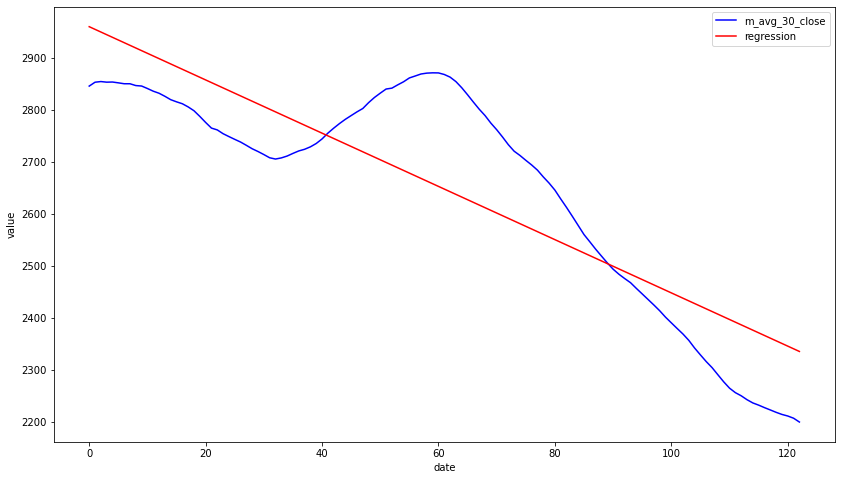

1366


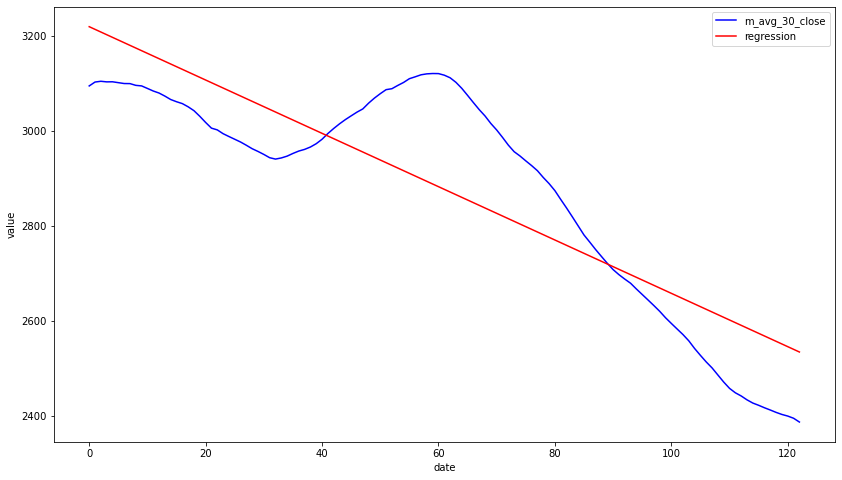

1368


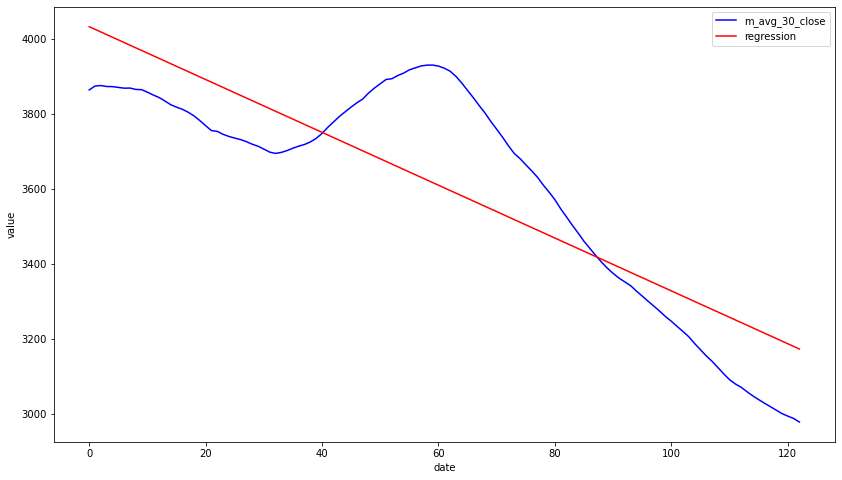

1459


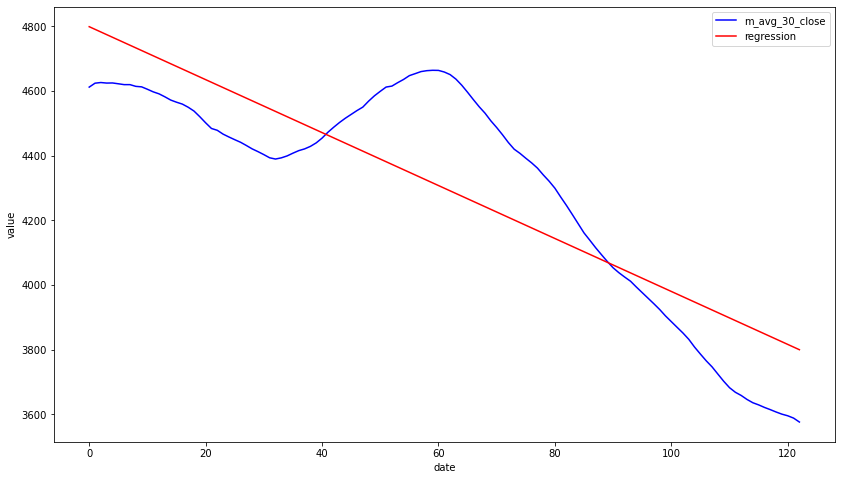

1569


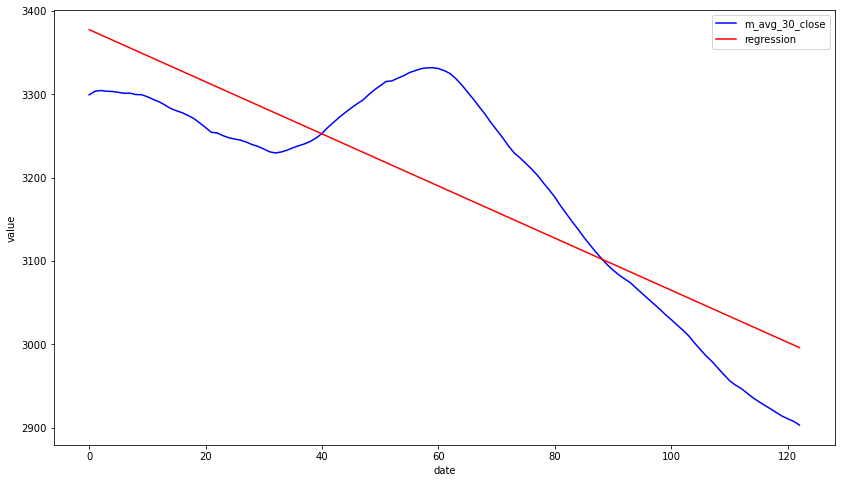

1571


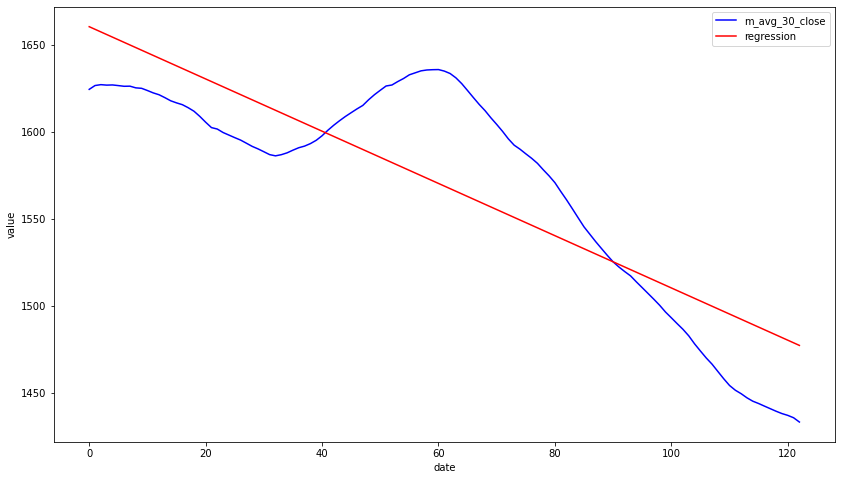

1580


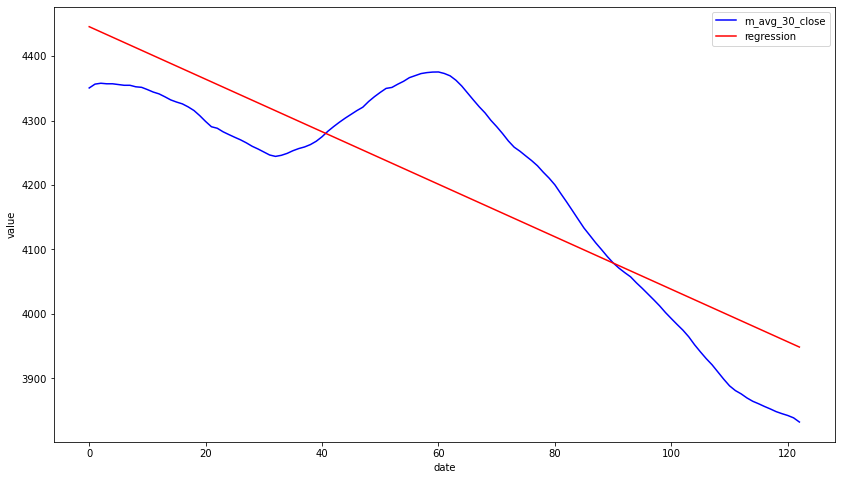

2041


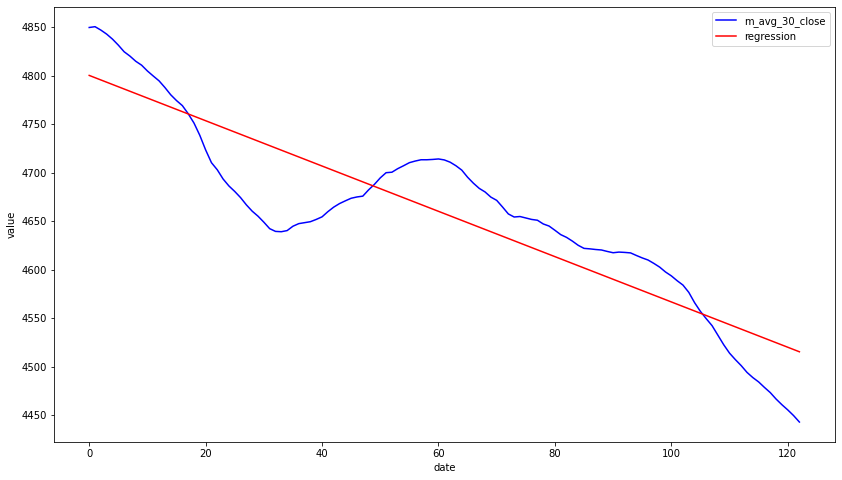

3689


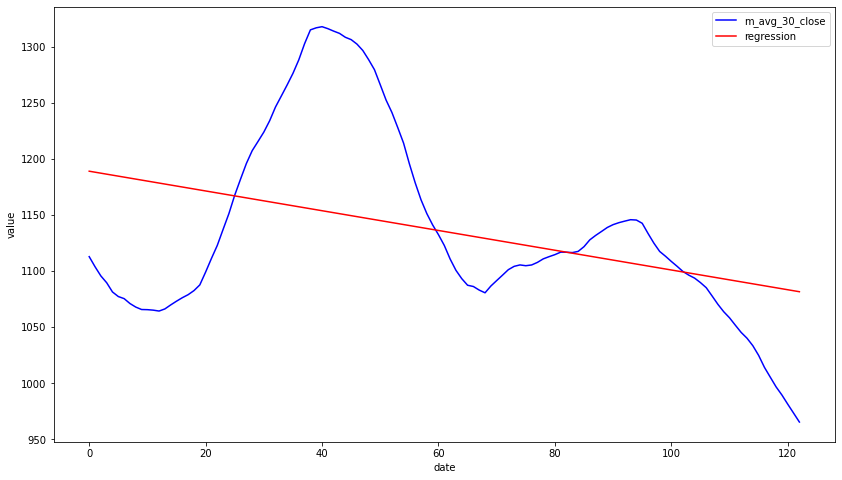

3926


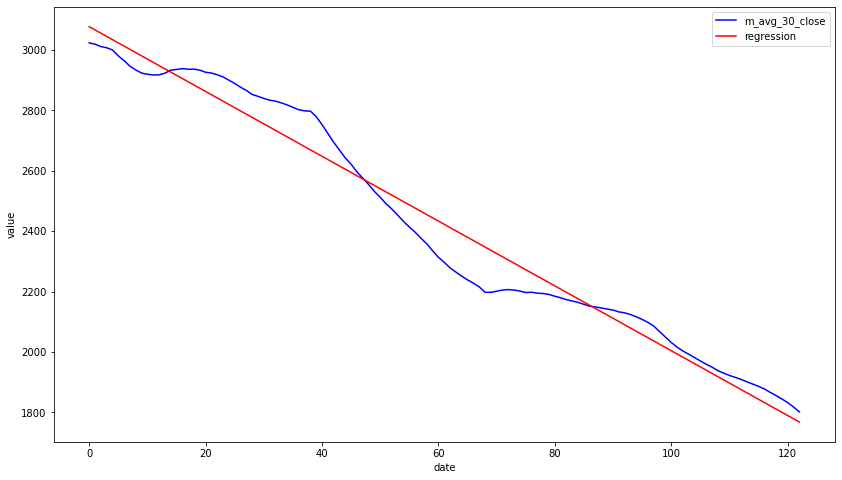

4558


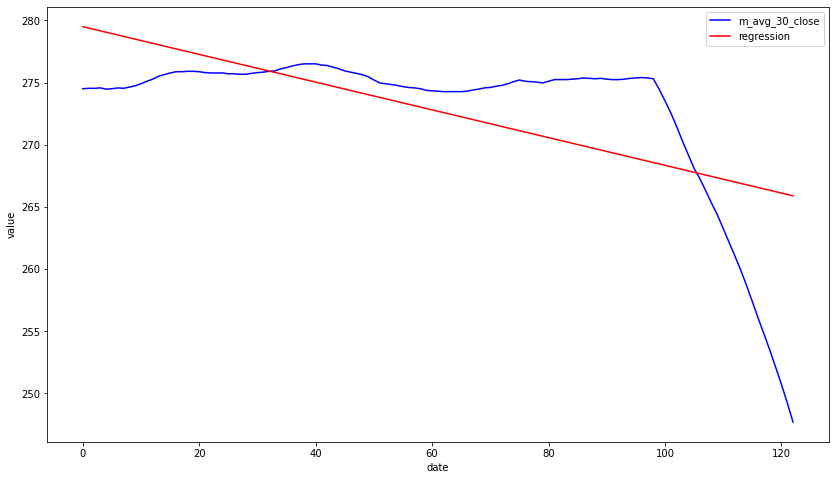

4680


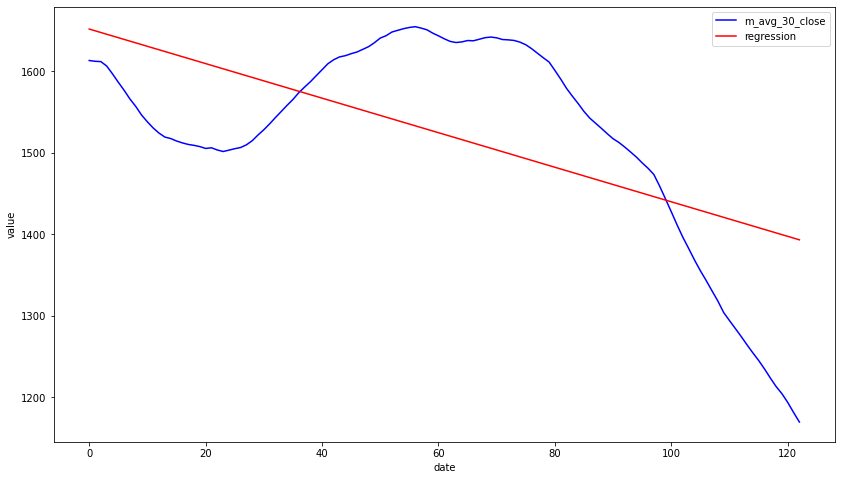

6547


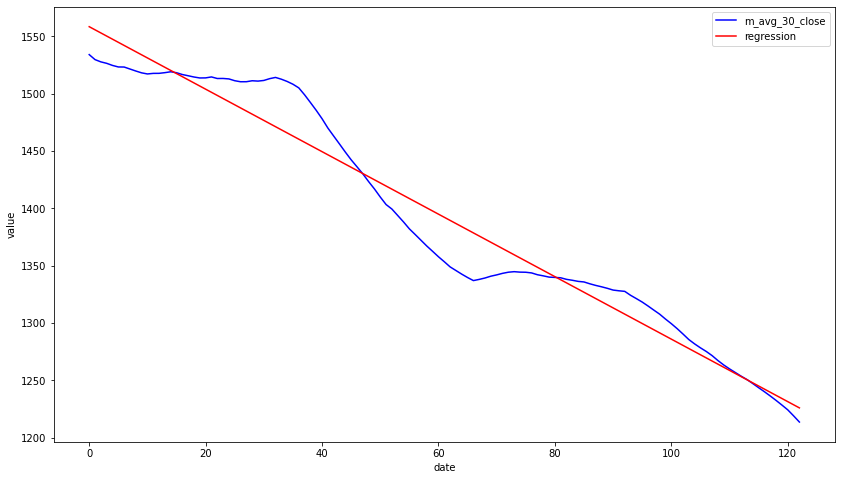

7519


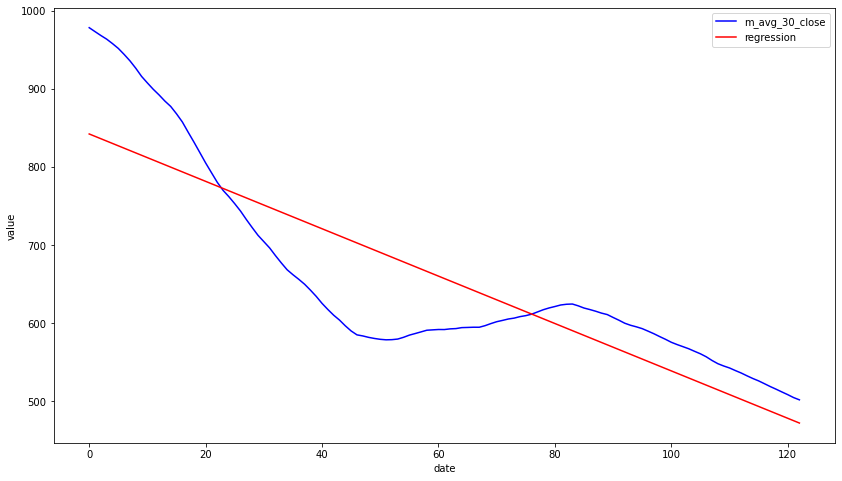

In [21]:
check_df = check(down_over_2std_codes, show_graph=True)

In [22]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0])

In [23]:
check_df.describe()

,grad,max_profit,max_days,min_profit,min_days
count,16.000000,16.000000,16.000000,16.000000,16.0
mean,-3.971723,1.045399,41.750000,-7.488167,122.0
std,2.836394,0.863736,25.637213,2.464507,0.0
min,-10.733639,0.200973,0.000000,-11.375047,122.0
25%,-5.245838,0.614819,28.750000,-9.259977,122.0
50%,-3.078133,0.714508,59.000000,-7.770696,122.0
75%,-2.148287,1.239327,59.000000,-6.996502,122.0
max,-0.111469,3.530285,60.000000,-1.202885,122.0


In [24]:
print('plus: {}'.format(plus / len(down_over_2std_codes)))
print('minus: {}'.format(minus / len(down_over_2std_codes)))

plus: 0.0
minus: 1.0


### -1.5σ ~ 2.0σ 下がった銘柄

In [25]:
check_df = check(down_between_1_5_and_2_0std_codes)

In [26]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0]) 

In [27]:
check_df.describe()

,grad,max_profit,max_days,min_profit,min_days
count,41.000000,41.000000,41.000000,41.000000,41.000000
mean,-2.825600,1.319026,16.000000,-4.993900,104.780488
std,4.361517,1.799195,23.014126,2.508392,30.416700
min,-23.420262,-0.594543,0.000000,-11.331730,4.000000
25%,-3.485373,0.493108,0.000000,-6.550691,108.000000
50%,-1.071837,0.926699,3.000000,-4.718852,122.000000
75%,-0.429692,1.320300,23.000000,-3.624611,122.000000
max,3.312239,8.013145,90.000000,0.750766,122.000000


In [28]:
print('plus: {}'.format(plus / len(down_between_1_5_and_2_0std_codes)))
print('minus: {}'.format(minus / len(down_between_1_5_and_2_0std_codes)))

plus: 0.04878048780487805
minus: 0.9512195121951219


In [29]:
check_df = check(down_between_1_0_and_1_5std_codes)

In [30]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0]) 

In [31]:
check_df.describe()

,grad,max_profit,max_days,min_profit,min_days
count,212.000000,212.000000,212.000000,212.000000,212.000000
mean,-1.980643,1.195612,22.641509,-3.554590,86.783019
std,3.980976,1.815043,29.657185,3.035623,30.386142
min,-35.249139,-2.046768,0.000000,-19.543498,0.000000
25%,-2.567373,0.343167,0.000000,-5.122632,63.750000
50%,-1.070032,0.907123,15.000000,-2.952367,85.000000
75%,-0.317234,1.509447,34.000000,-1.466831,122.000000
max,9.488989,19.043214,121.000000,0.909569,122.000000


In [32]:
print('plus: {}'.format(plus / len(down_between_1_0_and_1_5std_codes)))
print('minus: {}'.format(minus / len(down_between_1_0_and_1_5std_codes)))

plus: 0.11320754716981132
minus: 0.8867924528301887


In [33]:
check_df = check(down_between_0_5_and_1_0std_codes)

In [34]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0]) 

In [35]:
check_df.describe()

,grad,max_profit,max_days,min_profit,min_days
count,507.000000,507.000000,507.000000,507.000000,507.000000
mean,-0.717381,1.373553,47.988166,-2.439816,64.323471
std,2.492652,2.063274,46.112209,2.315261,30.254420
min,-25.127958,-2.682414,0.000000,-15.123340,0.000000
25%,-0.923558,0.459182,0.500000,-3.373933,59.000000
50%,-0.189683,1.060313,32.000000,-1.863125,63.000000
75%,0.150030,1.876762,99.000000,-0.841400,77.000000
max,12.506851,30.402451,122.000000,1.532993,122.000000


In [36]:
print('plus: {}'.format(plus / len(down_between_0_5_and_1_0std_codes)))
print('minus: {}'.format(minus / len(down_between_0_5_and_1_0std_codes)))

plus: 0.34714003944773175
minus: 0.6528599605522682


In [37]:
check_df = check(down_between_0_0_and_0_5std_codes)

In [38]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0]) 

In [39]:
check_df.describe()

,grad,max_profit,max_days,min_profit,min_days
count,515.000000,515.000000,515.000000,515.000000,515.000000
mean,0.158693,2.892707,78.553398,-2.166756,52.627184
std,3.921607,3.420509,48.210815,2.190825,31.727758
min,-30.733298,-1.738347,0.000000,-13.843751,0.000000
25%,-0.368323,0.830977,31.000000,-3.218631,22.500000
50%,0.156098,1.978766,109.000000,-1.747883,61.000000
75%,0.664038,4.011399,122.000000,-0.606119,65.000000
max,65.772401,24.206179,122.000000,1.871544,122.000000


In [40]:
print('plus: {}'.format(plus / len(down_between_0_0_and_0_5std_codes)))
print('minus: {}'.format(minus / len(down_between_0_0_and_0_5std_codes)))

plus: 0.6330097087378641
minus: 0.36699029126213595


In [41]:
check_df = check(up_between_0_0_and_0_5std_codes)

In [42]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0]) 

In [43]:
check_df.describe()

,grad,max_profit,max_days,min_profit,min_days
count,398.000000,398.000000,398.000000,398.000000,398.000000
mean,2.233681,4.124430,95.974874,-1.847943,47.389447
std,22.217495,3.838790,40.933556,2.063111,30.213624
min,-27.601449,-1.244495,0.000000,-13.619272,0.000000
25%,-0.005946,1.603252,87.250000,-2.799495,12.000000
50%,0.529151,3.410253,121.000000,-1.399379,60.000000
75%,1.667272,5.620609,122.000000,-0.364435,64.000000
max,420.217504,35.856696,122.000000,1.274132,122.000000


In [44]:
print('plus: {}'.format(plus / len(up_between_0_0_and_0_5std_codes)))
print('minus: {}'.format(minus / len(up_between_0_0_and_0_5std_codes)))

plus: 0.7412060301507538
minus: 0.25879396984924624


In [45]:
check_df = check(up_between_0_5_and_1_0std_codes)

In [46]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0]) 

In [47]:
check_df.describe()

,grad,max_profit,max_days,min_profit,min_days
count,354.000000,354.000000,354.000000,354.000000,354.000000
mean,11.759395,5.377637,100.878531,-1.583359,35.799435
std,68.344273,4.706406,34.410691,1.875342,30.966982
min,-9.120795,-1.784751,0.000000,-18.819855,0.000000
25%,0.321363,2.203480,97.000000,-2.438961,2.000000
50%,1.093519,4.432911,120.500000,-1.169470,48.000000
75%,2.681885,7.133972,122.000000,-0.355918,62.000000
max,865.250889,28.404111,122.000000,1.723292,120.000000


In [48]:
print('plus: {}'.format(plus / len(up_between_0_5_and_1_0std_codes)))
print('minus: {}'.format(minus / len(up_between_0_5_and_1_0std_codes)))

plus: 0.8587570621468926
minus: 0.14124293785310735


In [49]:
check_df = check(up_between_1_0_and_1_5std_codes)

In [50]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0]) 

In [51]:
check_df.describe()

,grad,max_profit,max_days,min_profit,min_days
count,332.000000,332.000000,332.000000,332.000000,332.000000
mean,29.499868,6.777278,103.701807,-1.303082,29.680723
std,114.101461,5.808501,31.570258,1.523725,29.576781
min,-5.785824,-1.001963,0.000000,-9.855363,0.000000
25%,0.486924,2.907148,98.000000,-1.935464,0.750000
50%,1.483517,5.529490,121.000000,-1.023290,14.000000
75%,3.730971,9.533499,122.000000,-0.188131,60.000000
max,1038.568551,50.136657,122.000000,1.252989,104.000000


In [52]:
print('plus: {}'.format(plus / len(up_between_1_0_and_1_5std_codes)))
print('minus: {}'.format(minus / len(up_between_1_0_and_1_5std_codes)))

plus: 0.8765060240963856
minus: 0.12349397590361445


In [53]:
check_df = check(up_between_1_5_and_2_0std_codes)

In [54]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0]) 

In [55]:
check_df.describe()

,grad,max_profit,max_days,min_profit,min_days
count,257.000000,257.000000,257.000000,257.000000,257.000000
mean,20.951023,7.389668,114.338521,-1.154711,30.054475
std,101.669668,5.650900,20.312553,1.319689,29.067354
min,-5.090842,-0.510673,8.000000,-7.176013,0.000000
25%,0.822361,3.683406,120.000000,-1.869490,0.000000
50%,2.339616,6.419759,122.000000,-1.002478,16.000000
75%,5.126743,9.812231,122.000000,-0.264519,60.000000
max,1005.640862,50.249130,122.000000,1.825020,114.000000


In [56]:
print('plus: {}'.format(plus / len(up_between_1_5_and_2_0std_codes)))
print('minus: {}'.format(minus / len(up_between_1_5_and_2_0std_codes)))

plus: 0.9416342412451362
minus: 0.058365758754863814


In [57]:
check_df = check(up_over_2std_codes)

In [58]:
plus = len(check_df[check_df['grad'] > 0])
minus = len(check_df[check_df['grad'] < 0]) 

In [59]:
check_df.describe()

,grad,max_profit,max_days,min_profit,min_days
count,352.000000,352.000000,352.000000,352.000000,352.000000
mean,7.180886,10.747204,119.244318,-1.139733,26.545455
std,29.997379,14.438261,12.671051,1.460541,28.058104
min,-8.156985,-0.996569,16.000000,-9.823893,0.000000
25%,1.106437,4.883078,122.000000,-1.755991,1.000000
50%,2.571447,7.562943,122.000000,-0.929121,11.000000
75%,5.561947,12.667247,122.000000,-0.079090,59.000000
max,503.324369,206.042407,122.000000,1.384897,99.000000


In [60]:
print('plus: {}'.format(plus / len(up_over_2std_codes)))
print('minus: {}'.format(minus / len(up_over_2std_codes)))

plus: 0.9772727272727273
minus: 0.022727272727272728


# 結論
平均より値下がりしている銘柄の方よりも、  
むしろ平均より高い銘柄がその後も値上がりしていた。    

これが、この日に限った傾向なのか要調査